# Data Science For Biology 2025 Final Project: Mutagenesis Development and Lead Protein Sequence Screening

## Libraries and Packages

In [199]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import joblib
from jsonschema.exceptions import best_match
from tqdm import tqdm
import metapredict as meta
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

## Screen For ADseq with Low SCGlucose Activity
Here I will load in the data as usual, but this time, I will sort by Activity_SCglucose in ascending order to have easier access to ADseq's which express low activity

In [200]:
data = pd.read_csv("./data/gcn4-orthologs.csv")
data = data.rename(columns={data.columns[0]: "tile_id"})
data.head()

,tile_id,DNAseq,ADseq,numreads_per_AD_7AGFP_AAS,Activity_7AGFP_AAS,numreads_per_AD_8AmCh_AAS,Activity_8AmCh_AAS,numreads_per_AD_9ARatio_AAS,Activity_9ARatio_AAS,numreads_per_AD_10BRatio_AAS,...,Activity_BYS4_BioRepAverage,Stdev_BYS4_BioReps,Activity_SCglucose,Start,Recovered,Activity_SCgalactose,Activity_P3promoter,Activity_P14promoter,Activity_P15promoter,Activity_P3promoterMig1TFBSremoved
0,0,AAAAATTCTAGATTTGTTTCTTTGATGCAAGGATTCTCTGATGGTT...,KNSRFVSLMQGFSDGSKDIIDNEVREVGDFSVNKPPQADD,NaN,NaN,NaN,NaN,NaN,NaN,3151.0,...,NaN,NaN,11666.48682,341,True,97250.68362,NaN,11149.49032,NaN,8040.343648
1,1,AAAAATTCTCCATCTGGTTTGGCTCATTCTTCTGTTTCTGGTGTTG...,KNSPSGLAHSSVSGVGKSRRRKGPLPPITVQDPSDKTAIK,942.0,709.606092,367.0,2921.917252,601.0,22242.74698,6909.0,...,21968.05843,5849.143385,21968.05843,146,True,15516.96245,14570.13217,16872.28649,11555.08411,10255.296840
2,2,AAACAAAATTCTCAAGTTGATCAATCTCCATTGTTGCCAGAAGAAG...,KQNSQVDQSPLLPEEELEVSEHLRRRRSGTATSPPAGGVR,NaN,NaN,NaN,NaN,NaN,NaN,6577.0,...,NaN,NaN,21203.02478,326,True,0.00000,18274.98241,15702.60901,18303.29201,17265.783330
3,3,AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATG...,KQRATPLTPVVPESDDPVALKRARNTEAARRSRARKLERM,357.0,1039.469842,342.0,1089.428196,450.0,74251.36241,NaN,...,NaN,NaN,47244.41248,246,True,92844.00000,NaN,NaN,NaN,84807.518160
4,4,AAACAAAGATCTATTCCATTGTCTCCAATTGTTCCAGAATCTTCTG...,KQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRM,539.0,1081.980998,627.0,622.131501,586.0,58872.95132,128.0,...,95093.69451,13292.686710,95093.69451,211,True,76399.62949,NaN,125056.17980,129302.35080,100360.735500


In [201]:
# Sort by activity_SCglucose
activity = "Activity_SCglucose"
low_activity_df = data.sort_values(by=[activity], ascending=True)
low_activity_df = low_activity_df[['ADseq', activity]].dropna()
low_activity_df


,ADseq,Activity_SCglucose
12676,VLASNDLLLPHPTSPHYSAPSFANKPATWRLNKLSLLCST,6138.0
14056,SKSGVKHSTVAGVNARQRKPLPPIKVDPSDPVALKRARNT,6138.0
16841,FYQRRIMSTPNIGQDMSDFFDLPSNHFGEDFDFTTEPTML,6138.0
3711,RKLERQDVMERRIAELEKSLEEAEQREQYWKAMAQAQTQV,6138.0
3906,MTLFGWVQLAKDSMAHSILHGKKHNDVAHDEELSPEQVVK,6138.0
...,...,...
9454,DIGESPYLDNYDQSPGIFAGDAVMASDNWFSLFPEDDIKV,262143.0
9449,DIDASPFLNESFETSPMFQGEPLMNNSNDWFSLFPEEENK,262143.0
6693,PMINTEMDLNAAPEEWESLFPQDGFPLDLDSAALELAVSL,262143.0
1371,NLDGVNDIDHTPMFDELDLIMDGAKVNSSEDWVALFGDDN,262143.0


In [202]:
# Let's look at the min and max values of the activity
low_activity_df.describe()

,Activity_SCglucose
count,18944.000000
mean,66087.894674
std,61869.279225
min,6138.000000
25%,24438.359877
50%,43490.494810
75%,77276.723883
max,262143.000000


## In Silico Directed Evolution
Without loss of generality, let's simply pick the protein sequence with the lowest activity and do some a random pointwise mutation. We then repeat this process across $N$ generations. First I will add sequence features so that we can use the random forest model to predict the SCGlucose activity. The reason for this is because the model is very strict with the columns we provide for prediction. It must be named and ordered exactly the same as how we trained the model initially or scikit-learn will complain!

In [203]:
# FEATURES

# variables I need globally
AA_LIST = 'ACDEFGHIKLMNPQRSTVWY'
AA_COLS = [f"AA_{aa}" for aa in AA_LIST]

# I use Kyte-Doolittle scale for hydrophobicity here CHECK WITH PROF STALLER
# https://www.rbvi.ucsf.edu/chimera/docs/UsersGuide/midas/hydrophob.html
KD_HYDROPHOBICITY = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8,
    'G': -0.4, 'H': -3.2, 'I': 4.5, 'K': -3.9, 'L': 3.8,
    'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5,
    'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
}

# i use the tuple here for naming the motifs
MOTIFS = [
    ("W..LF", "W..LF"),
    ("WFYL_WFYL", "[WFYL]..[WFYL][WFYL]"),
    ("WFL_WFL", "[WFL]..[WFL][WFL]"),
    ("DE_WFY", "[DE][WFY]"),
    ("DE_WF", "[DE][WF]"),
    ("DE_L", "[DE][L]"),
    ("DE_x_WFY", "[DE].[WFY]"),
    ("DE_xx_WFY", "[DE]..[WFY]"),
    ("FF", "FF"),
    ("F_F", "F.F"),
    ("F__F", "F..F"),
    ("FY_5x_FY", "[FY].....[FY]"),
    ("SP", "SP"),
    ("WFYL_3x_WFYL", "[WFYL]...[WFYL][WFYL]")
]

# FUNCTIONS TO CALC

def amino_acid_count(sequence: str) -> dict[str, int]:
    c = Counter(sequence)
    return {f"AA_{aa}": c.get(aa, 0) for aa in AA_LIST}

def net_charge(seq: str) -> int:
    charge_map = {"K": 1, "R": 1, "D": -1, "E": -1}
    return sum(charge_map.get(a, 0) for a in seq)

def hydrophobicity(sequence: str) -> float:
    total_hydrophobicity = sum(KD_HYDROPHOBICITY[aa] for aa in sequence if aa in KD_HYDROPHOBICITY)
    return total_hydrophobicity

def motif_counts_dict(seq: str) -> dict[str, int]:
    return {name: len(re.findall(pat, seq)) for name, pat in MOTIFS}

# APPLY DA FEATURESSSS
def add_sequence_features(df: pd.DataFrame, seq_col: str = "ADseq") -> pd.DataFrame:
    # AA composition
    aa_expanded = df[seq_col].apply(amino_acid_count).apply(pd.Series)
    
    # Motif counts
    motif_expanded = df[seq_col].apply(motif_counts_dict).apply(pd.Series)

    # Scalar features
    df["NetCharge"] = df[seq_col].apply(net_charge)
    df["Hydrophobicity"] = df[seq_col].apply(hydrophobicity)
    
    # Sequence length
    df["Length"] = df[seq_col].str.len()

    # Combine everything
    result_df = pd.concat([df, aa_expanded, motif_expanded], axis=1)

    return result_df

In [204]:
low_activity_df = add_sequence_features(low_activity_df, seq_col="ADseq")

# now we put Activity_SCglucose as the last column for convenience
low_activity_df = low_activity_df[[col for col in low_activity_df.columns if col != activity] + [activity]]
low_activity_df.head()

,ADseq,NetCharge,Hydrophobicity,Length,AA_A,AA_C,AA_D,AA_E,AA_F,AA_G,...,DE_L,DE_x_WFY,DE_xx_WFY,FF,F_F,F__F,FY_5x_FY,SP,WFYL_3x_WFYL,Activity_SCglucose
12676,VLASNDLLLPHPTSPHYSAPSFANKPATWRLNKLSLLCST,2,-2.7,40,4,1,1,0,1,0,...,1,0,0,0,0,0,0,1,0,6138.0
14056,SKSGVKHSTVAGVNARQRKPLPPIKVDPSDPVALKRARNT,7,-31.3,40,4,0,2,0,0,2,...,0,0,0,0,0,0,0,0,0,6138.0
16841,FYQRRIMSTPNIGQDMSDFFDLPSNHFGEDFDFTTEPTML,-5,-23.7,40,0,0,5,2,6,2,...,1,2,1,1,1,0,1,0,0,6138.0
3711,RKLERQDVMERRIAELEKSLEEAEQREQYWKAMAQAQTQV,-1,-53.3,40,5,0,1,8,0,0,...,1,1,1,0,0,0,0,0,0,6138.0
3906,MTLFGWVQLAKDSMAHSILHGKKHNDVAHDEELSPEQVVK,-2,-17.8,40,3,0,3,3,1,2,...,1,0,0,0,0,0,0,1,0,6138.0


Great! Now what we're going to do is simply take the first row which corresponds to the ADseq with low SCglucose activity. We will also take note of its corresponding activity value for comparison later on!

In [205]:
protein_sequence = low_activity_df.iloc[0, 0]
activity_value = low_activity_df.iloc[0, -1]
print(f"Protein sequence: {protein_sequence}")
print(f"Activity value: {activity_value}")

Protein sequence: VLASNDLLLPHPTSPHYSAPSFANKPATWRLNKLSLLCST
Activity value: 6138.0


Below I define two functions. The first `mutate_sequence` allows us do a single pointwise mutation on the protein sequence in a controlled manner where we can specify the position and the replacing amino acid for the selected protein sequence. The second, `simulate_mutations_over_generations` is an algorithm I developed to perform in silico directed evolution. The key idea is simple: starting from a single protein sequence, we simulate evolutionary pressure by introducing pointwise mutations over multiple generations.

In each generation:

1. We create many mutated versions of the current sequences by randomly changing one amino acid at a time.

2. These new sequences are passed through a custom function that evaluates their properties (e.g., activity, structure, or other learned features).

3. We keep the most promising variants and use them as the parents for the next generation.

I guese over time, the idea is that this process mimics natural selection but virtually. It allows us to efficiently explore the sequence space and evolve toward desired traits without ever going into the lab. Note if you're going to run this, it's gonna take a while T_T (10-15 mins max). I've yet to optimize this and this is very much so a brute force approach with nested for-loops resulting in O(n^3) time complexity

In [206]:
# mutate the protein sequence pointwise
def mutate_sequence(seq: str, pos: int, new_aa: str) -> str:
    if pos < 0 or pos >= len(seq):
        raise ValueError("Position out of range")
    if new_aa not in AA_LIST:
        raise ValueError("Invalid amino acid")
    return seq[:pos] + new_aa + seq[pos + 1:]

# TODO: OPTIMIZE THE SHIZ OUT OF THIS
def simulate_mutations_over_generations(
    initial_sequence,
    aa_list,
    add_features_fn,
    num_generations=10,
    num_mutations_per_generation=1000,
    max_sequences_per_gen=5000
):
    current_sequences = [initial_sequence]
    all_generations = []

    for gen in tqdm(range(num_generations), desc="Simulating generations", position=0, leave=True):
        mutated_sequences = set()

        for seq in tqdm(current_sequences, desc=f"Mutating sequences (Gen {gen+1})", position=1, leave=False):
            seq_array = np.array(list(seq))
            mutation_positions = np.random.randint(0, len(seq), size=num_mutations_per_generation)
            mutation_aas = np.random.choice(aa_list, size=num_mutations_per_generation)

            for pos, new_aa in zip(mutation_positions, mutation_aas):
                new_seq = seq_array.copy()
                new_seq[pos] = new_aa
                mutated_sequences.add("".join(new_seq))
        
        # DEFO NEED TO LIMIT THIS WAS TOO SLOW
        if len(mutated_sequences) > max_sequences_per_gen:
            mutated_sequences = np.random.choice(
                list(mutated_sequences),
                size=max_sequences_per_gen,
                replace=False
            ).tolist()
        else:
            mutated_sequences = list(mutated_sequences)

        mutated_df = pd.DataFrame(mutated_sequences, columns=["ADseq"])
        mutated_df["Generation"] = gen + 1

        mutated_df = add_features_fn(mutated_df, seq_col="ADseq")
        all_generations.append(mutated_df)

        current_sequences = mutated_sequences

    result_df = pd.concat(all_generations, ignore_index=True)
    return result_df


In [207]:
result = simulate_mutations_over_generations(
    protein_sequence, 
    list(AA_LIST), 
    add_sequence_features,
    num_generations=5, 
    num_mutations_per_generation=1000
)

result.head()

Mutating sequences (Gen 1):   0%|          | 0/1 [00:00<?, ?it/s]
                                                                 
Simulating generations: 100%|██████████| 5/5 [01:11<00:00, 14.36s/it]           


,ADseq,Generation,NetCharge,Hydrophobicity,Length,AA_A,AA_C,AA_D,AA_E,AA_F,...,DE_WF,DE_L,DE_x_WFY,DE_xx_WFY,FF,F_F,F__F,FY_5x_FY,SP,WFYL_3x_WFYL
0,VLASNDLLLPHPTSPHYSAPSFANKPATWRLNKLSLLCLT,1,2,1.9,40,4,1,1,0,1,...,0,1,0,0,0,0,0,0,1,0
1,VLASNDLLLPHPTSPHYSAPSFANKPATWRLNKLSALCST,1,2,-4.7,40,5,1,1,0,1,...,0,1,0,0,0,0,0,0,1,0
2,VLASNDLLLWHPTSPHYSAPSFANKPATWRLNKLSLLCST,1,2,-2.0,40,4,1,1,0,1,...,0,1,0,0,0,0,0,0,1,0
3,VLASNDLLLSHPTSPHYSAPSFANKPATWRLNKLSLLCST,1,2,-1.9,40,4,1,1,0,1,...,0,1,0,0,0,0,0,0,1,0
4,VLASNDLLLPHPWSPHYSAPSFANKPATWRLNKLSLLCST,1,2,-2.9,40,4,1,1,0,1,...,0,1,0,0,0,0,0,0,1,0


Now that we have our mutated sequences, we will use use our trained model from the activity-predictor notebook where in this case I'm using the random forest model trained only on computed features and not utilizing ESM embeddings since it scored the best in terms of Pearson R^2. We will use the random forest model to predict the activity_SCglucose for our mutated sequences!

In [208]:
# Load the regression model
model = joblib.load("./models/random_forest_model.pkl")

mutated_feature = result.drop(columns=["ADseq", "Generation"])

# Make predictions on the mutated sequence
predictions = model.predict(mutated_feature)

# Add predictions to the DataFrame
result["Activity_SCglucose"] = predictions

result.head()

,ADseq,Generation,NetCharge,Hydrophobicity,Length,AA_A,AA_C,AA_D,AA_E,AA_F,...,DE_L,DE_x_WFY,DE_xx_WFY,FF,F_F,F__F,FY_5x_FY,SP,WFYL_3x_WFYL,Activity_SCglucose
0,VLASNDLLLPHPTSPHYSAPSFANKPATWRLNKLSLLCLT,1,2,1.9,40,4,1,1,0,1,...,1,0,0,0,0,0,0,1,0,56087.618170
1,VLASNDLLLPHPTSPHYSAPSFANKPATWRLNKLSALCST,1,2,-4.7,40,5,1,1,0,1,...,1,0,0,0,0,0,0,1,0,57855.484404
2,VLASNDLLLWHPTSPHYSAPSFANKPATWRLNKLSLLCST,1,2,-2.0,40,4,1,1,0,1,...,1,0,0,0,0,0,0,1,0,59626.262889
3,VLASNDLLLSHPTSPHYSAPSFANKPATWRLNKLSLLCST,1,2,-1.9,40,4,1,1,0,1,...,1,0,0,0,0,0,0,1,0,61107.880628
4,VLASNDLLLPHPWSPHYSAPSFANKPATWRLNKLSLLCST,1,2,-2.9,40,4,1,1,0,1,...,1,0,0,0,0,0,0,1,0,57922.870610


### Screening with Meta Predict

Naturally the next thing to do is to find which of these mutations is predicted to have the highest scglucose_activity.

However, the relationship between AD sequences and functions are significantly impacted by conserved motifs and their intrinsic disorder. So our optimal candidate should also maintain the intrinsically disordered structure characteristic of functional activation domains.

Here we use MetaPredict to predict the disorder scores per residue for the top candidates and their corresponding original sequences. We may accept the second, third, or even the hundredth candidate if the earlier ones cannot maintain overall disorderness close to the original!

###### https://www.cell.com/biophysj/fulltext/S0006-3495(21)00725-6
###### A cutoff of 0.3 offers a good balance between true positives and false negatives
###### So here scores larger than 0.3 correspond to disordered residues

In [209]:
def select_best_candidate_with_disorder_constraint(
    result_df,             # DataFrame containing mutated sequences and predicted activities
    protein_sequence,      # Original sequence
    meta,
    disorder_threshold=0.01  # Maximum allowed disorder difference
):

    # The mean disorder for the original sequence
    original_disorder_mean = np.mean(meta.predict_disorder(protein_sequence))

    # Sort the result by activity in descending order
    result_df_sorted = result_df.sort_values(by="Activity_SCglucose", ascending=False)

    # Iterate over the sorted candidates and check the disorder difference
    for rank, (idx, row) in enumerate(result_df_sorted.iterrows()):
        mutated_sequence = row["ADseq"]
        mutated_disorder_mean = np.mean(meta.predict_disorder(mutated_sequence))

        disorder_difference = abs(mutated_disorder_mean - original_disorder_mean)

        if rank == 0:
            print(f"Top-1 activity candidate disorder difference: {disorder_difference:.4f}")
            print(f"Top-1 activity: {row['Activity_SCglucose']:.4f}")

        if disorder_difference < disorder_threshold:
            print(f"Final candidate's disorder difference: {disorder_difference}")
            print(f"Final candidate's activity: {row['Activity_SCglucose']:.4f}")
            best = result_df_sorted.iloc[[rank]]
            return best

    return None # No valid candidate is found

In [210]:
best_candidate = select_best_candidate_with_disorder_constraint(result, protein_sequence, meta, 0.01)

Top-1 activity candidate disorder difference: 0.3620
Top-1 activity: 114208.3937
Final candidate's disorder difference: 0.008692622184753418
Final candidate's activity: 77510.2644


In [211]:
if best_candidate is not None:
    display(best_candidate)
else:
    print("No candidate met the disorder constraint.")

,ADseq,Generation,NetCharge,Hydrophobicity,Length,AA_A,AA_C,AA_D,AA_E,AA_F,...,DE_L,DE_x_WFY,DE_xx_WFY,FF,F_F,F__F,FY_5x_FY,SP,WFYL_3x_WFYL,Activity_SCglucose
5602,VLASNDLLLPSPTSPHYSAPSFANKPATWRLNTLSLECST,3,0,-4.4,40,4,1,1,1,1,...,1,0,0,0,0,0,0,2,0,77510.264444


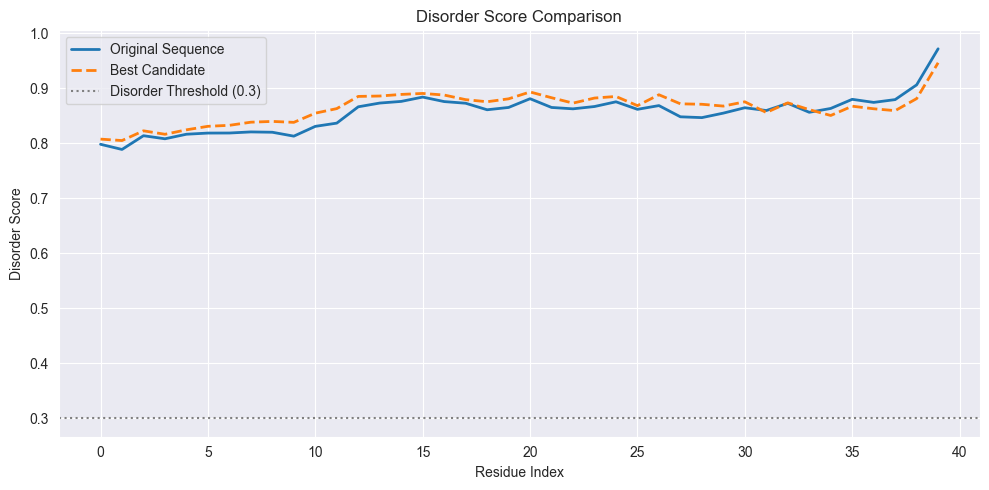

In [212]:
best_candidate_disorder_scores = meta.predict_disorder(best_candidate["ADseq"].values[0])
original_disorder_scores = meta.predict_disorder(protein_sequence)

# visualize the disorder difference between our top candidate and the original seq
plt.figure(figsize=(10, 5))
plt.plot(original_disorder_scores, label="Original Sequence", linewidth=2)
plt.plot(best_candidate_disorder_scores, label="Best Candidate", linewidth=2, linestyle="--")
plt.axhline(0.3, color='gray', linestyle=':', label="Disorder Threshold (0.3)")
plt.xlabel("Residue Index")
plt.ylabel("Disorder Score")
plt.title("Disorder Score Comparison")
plt.legend()
plt.tight_layout()
plt.show()

I believe what we can tell from this is that our top candidate here is likely to maintain the intrinsically disordered structure characteristic of functional activation domains. The plot above shows that the improved predicted activity did not come at the cost of order-disorder balance which is a good things and it might even hint at the possibility that slight modulation in specific regions could be beneficial

### Cross-Examination Between Original and Mutated Sequences

In [213]:
top_candidate = best_candidate.iloc[0]
print(f"Top candidate sequence: {top_candidate['ADseq']}")
print(f"Original sequence: {protein_sequence}")
print(f"Original activity: {activity_value}")
print(f"Predicted activity: {top_candidate['Activity_SCglucose']}")

Top candidate sequence: VLASNDLLLPSPTSPHYSAPSFANKPATWRLNTLSLECST
Original sequence: VLASNDLLLPHPTSPHYSAPSFANKPATWRLNKLSLLCST
Original activity: 6138.0
Predicted activity: 77510.26444370001


In [214]:
# i wanna see how these two are different
def compare_sequences(seq1: str, seq2: str) -> list[tuple[int, str, str]]:
    differences = []
    for i, (a, b) in enumerate(zip(seq1, seq2)):
        if a != b:
            differences.append((i, a, b))
    return differences
differences = compare_sequences(protein_sequence, top_candidate["ADseq"])
print("Differences between original and top candidate:")
for pos, original_aa, new_aa in differences:
    print(f"Position {pos}: {original_aa} -> {new_aa}")

Differences between original and top candidate:
Position 10: H -> S
Position 32: K -> T
Position 36: L -> E


In [215]:
# Let's check the difference in net charge and hydrophobicity
original_net_charge = net_charge(protein_sequence)
top_candidate_net_charge = net_charge(top_candidate["ADseq"])
print(f"Original net charge: {original_net_charge}")
print(f"Top candidate net charge: {top_candidate_net_charge}")
print(f"Net charge difference: {top_candidate_net_charge - original_net_charge}")


original_hydrophobicity = hydrophobicity(protein_sequence)
top_candidate_hydrophobicity = hydrophobicity(top_candidate["ADseq"])
print(f"Original hydrophobicity: {original_hydrophobicity}")
print(f"Top candidate hydrophobicity: {top_candidate_hydrophobicity}")
print(f"Hydrophobicity difference: {top_candidate_hydrophobicity - original_hydrophobicity}")

Original net charge: 2
Top candidate net charge: 0
Net charge difference: -2
Original hydrophobicity: -2.700000000000002
Top candidate hydrophobicity: -4.400000000000002
Hydrophobicity difference: -1.7000000000000002


### Degradation Analysis
Would be nice but DegRon is a bit more troublesome to get setup

### Abundance Analysis

Would have to figure out what abundance databases there are for yeast, I'm sure there exists something out there

IF NOT, biopython seems to have a protein analysis module that indicators like:

1. instability
2. aromaticity
3. gravy (LOL it's supposed to correspond to hydrophobicity)